In [2]:
import sys

sys.path.append('..')

import os

import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.colors import LogNorm, Normalize

from models.unrolled_admm_gaussian import UnrolledADMMGaussian
from utils.utils_test import PSNR, estimate_shear

os.environ["CUDA_VISIBLE_DEVICES"] = '2'
# DATA_DIR = '/mnt/WD6TB/tianaoli/dataset/LSST_23.5_deconv/'
DATA_DIR = '../tutorials/'
SAVED_MODEL_DIR = '../saved_models_2024/'

cmap = 'magma'

In [3]:
snr_list = [100]
psf = torch.load(os.path.join(DATA_DIR,  "psf.pth"))
gt_list, obs_list = [torch.load(os.path.join(DATA_DIR,  "gt.pth"))], [torch.load(os.path.join(DATA_DIR,  "obs.pth"))]

In [4]:
n_iters_list, best_epoch_list = [2, 4, 8], [16, 13, 38]
rec_admm = [[], [], []]

for idx, (n_iters, best_epoch) in enumerate(zip(n_iters_list, best_epoch_list)):
    model = UnrolledADMMGaussian(n_iters=n_iters, PnP=True, subnet=True, analysis=True)
    model.cuda()
    model.eval()
    model_file = os.path.join(SAVED_MODEL_DIR, f'Gaussian_PnP_ADMM_{n_iters}iters_MultiScale_{best_epoch}epochs.pth')
    model.load_state_dict(torch.load(model_file, map_location=torch.device('cuda:0')))
    print(f'Successfully loaded in {model_file}.')

    for obs, gt in zip(obs_list, gt_list):
        alpha = obs.ravel().mean().view(1,1,1,1)
        x_list, z_list, u_list, rho_list = model(obs.unsqueeze(0).unsqueeze(0).cuda(), psf.unsqueeze(0).unsqueeze(0).cuda(), alpha.cuda())
        x_list = [rec.cpu().squeeze(0).squeeze(0).detach().numpy() for rec in x_list]
        z_list = [rec.cpu().squeeze(0).squeeze(0).detach().numpy() for rec in z_list]
        rho_list = np.array([rho.view(1).detach().cpu().numpy() for rho in rho_list])
        u_list = [u1.cpu().squeeze(0).squeeze(0).detach().numpy() for u1 in u_list]
        rec_admm[idx].append((x_list, z_list, u_list, rho_list))

Successfully loaded in ../saved_models_2024/Gaussian_PnP_ADMM_2iters_MultiScale_16epochs.pth.
Successfully loaded in ../saved_models_2024/Gaussian_PnP_ADMM_4iters_MultiScale_13epochs.pth.
Successfully loaded in ../saved_models_2024/Gaussian_PnP_ADMM_8iters_MultiScale_38epochs.pth.


/tmp/ipykernel_3270075/1091317589.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,4,4*idx+1)


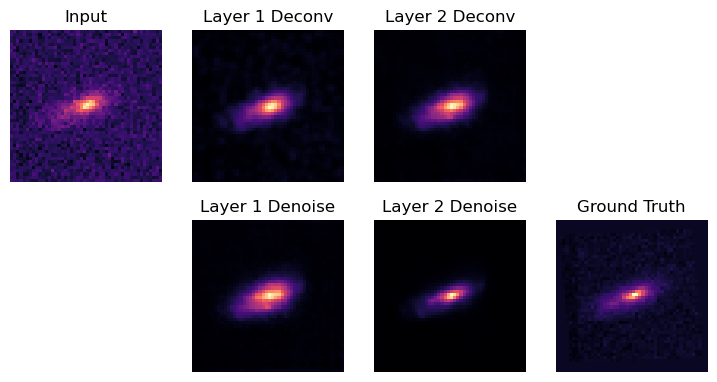

In [5]:
fig = plt.figure(figsize=(9,7), facecolor='white')
ax = plt.gca()

for idx, (snr, gt, obs, (x_list, z_list, u_list, rho_list)) in enumerate(zip(snr_list, gt_list, obs_list, rec_admm[0])):
    vmax = np.max([obs[0].max(), z_list[-1].max()])
    vmin = np.min([obs[0].min(), z_list[-1].min()])
    norm = matplotlib.colors.Normalize(vmax=vmax, vmin=vmin)

    plt.subplot(3,4,4*idx+1)
    plt.imshow(obs, cmap=cmap)
    plt.title('Input')
    plt.axis('off')
    
    plt.subplot(3,4,4*idx+8)
    plt.imshow(gt, cmap=cmap)
    plt.title('Ground Truth')
    plt.axis('off')
    
    for i in range(2):
        plt.subplot(3,4,4*idx+i+2)
        plt.imshow(rho_list[i]*z_list[i]+u_list[i], cmap=cmap)
        plt.axis('off')
        plt.title(f'Layer {i+1} Deconv')
        
        plt.subplot(3,4,4*idx+i+2+4)
        plt.imshow(z_list[i], cmap=cmap)
        plt.axis('off')
        plt.title(f'Layer {i+1} Denoise')
        # plt.imsave(f'../figures/press_release/Unrolled-ADMM(8)_SNR={snr}_layer{i+1}.jpg', rec, cmap=cmap)

/tmp/ipykernel_3270075/2027386881.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,6,6*idx+1)


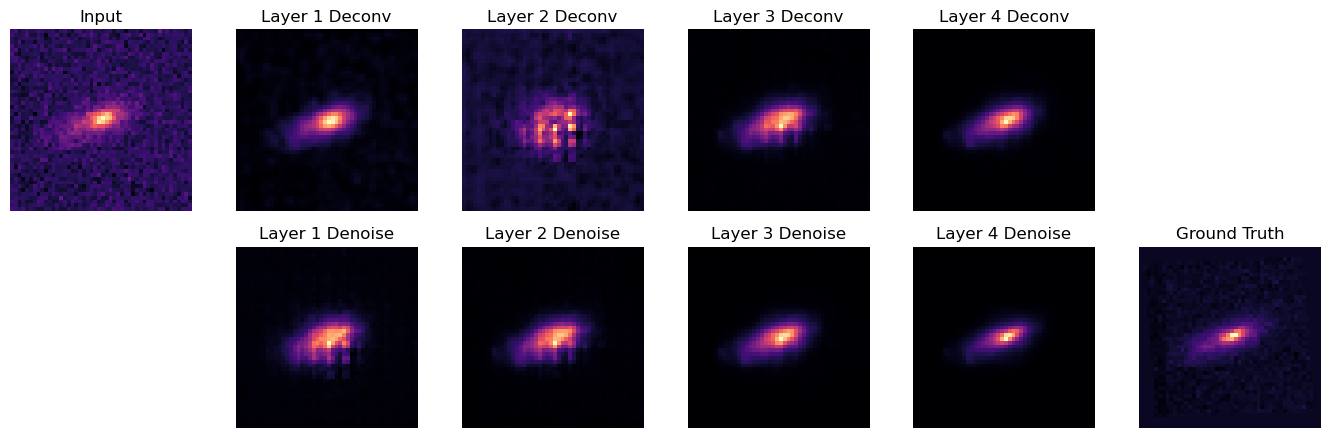

In [6]:
fig = plt.figure(figsize=(17,8), facecolor='white')
ax = plt.gca()

for idx, (snr, gt, obs, (x_list, z_list, u_list, rho_list)) in enumerate(zip(snr_list, gt_list, obs_list, rec_admm[1])):
    vmax = gt.max()
    vmin = gt.min()
    norm = matplotlib.colors.Normalize(vmax=vmax, vmin=vmin)

    plt.subplot(3,6,6*idx+1)
    plt.imshow(obs, cmap=cmap)
    plt.title('Input')
    plt.axis('off')
    
    plt.subplot(3,6,6*idx+12)
    plt.imshow(gt, cmap=cmap)
    plt.title('Ground Truth')
    plt.axis('off')
    
    for i in range(4):
        plt.subplot(3,6,6*idx+i+2)
        plt.imshow(x_list[i], cmap=cmap)
        plt.axis('off')
        plt.title(f'Layer {i+1} Deconv')
        
        plt.subplot(3,6,6*idx+i+2+6)
        plt.imshow(z_list[i], cmap=cmap)
        plt.axis('off')
        plt.title(f'Layer {i+1} Denoise')
        # plt.imsave(f'../figures/press_release/Unrolled-ADMM(4)_SNR={snr}_layer{i+1}.jpg', z_list[i], cmap=cmap)


/tmp/ipykernel_3270075/1570090573.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,10,10*idx+1)


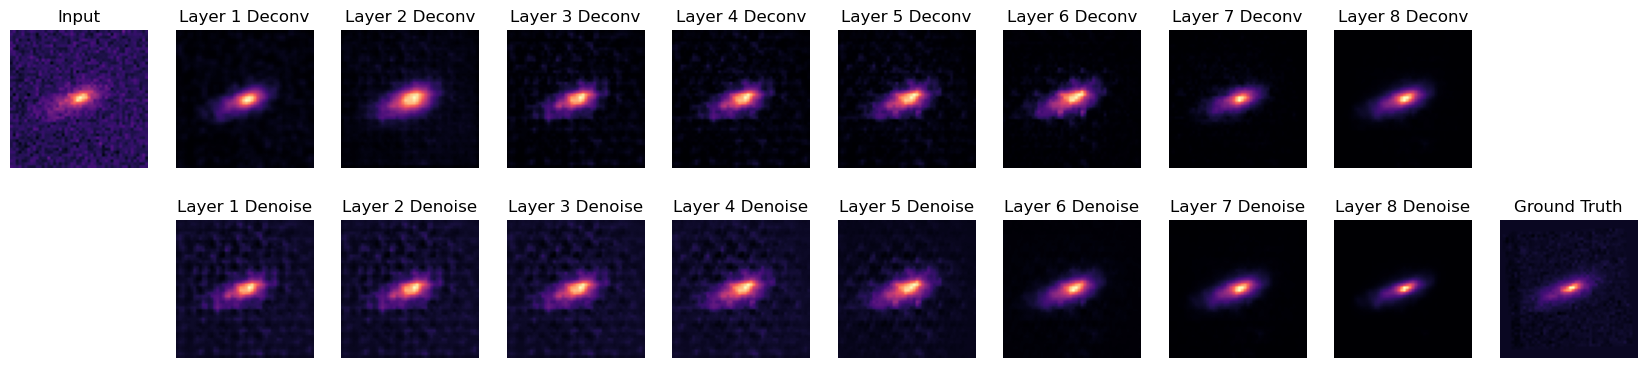

In [7]:
fig = plt.figure(figsize=(21,7), facecolor='white')
ax = plt.gca()

for idx, (snr, gt, obs, (x_list, z_list, u_list, rho_list)) in enumerate(zip(snr_list, gt_list, obs_list, rec_admm[2])):
    vmax = 2*np.max([obs[0].max(), z_list[-1].max()])
    vmin = 0*np.min([obs[0].min(), z_list[-1].min()])
    norm = matplotlib.colors.Normalize(vmax=vmax, vmin=vmin)

    plt.subplot(3,10,10*idx+1)
    plt.imshow(obs, cmap=cmap)
    plt.title('Input')
    plt.axis('off')
    
    plt.subplot(3,10,10*idx+20)
    plt.imshow(gt, cmap=cmap)
    plt.title('Ground Truth')
    plt.axis('off')
    
    for i in range(8):
        plt.subplot(3,10,10*idx+i+2)
        plt.imshow(np.abs(x_list[i]), cmap=cmap)
        plt.axis('off')
        plt.title(f'Layer {i+1} Deconv')
        
        plt.subplot(3,10,10*idx+i+2+10)
        plt.imshow((z_list[i]), cmap=cmap)
        plt.axis('off')
        plt.title(f'Layer {i+1} Denoise')
        
        # plt.subplot(3,10,10*idx+i+2+20)
        # plt.imshow(u_list[i], cmap=cmap)
        # plt.axis('off')
        # plt.title(f'Layer {i+1} Dual')
        # plt.imsave(f'../figures/press_release/Unrolled-ADMM(8)_SNR={snr}_layer{i+1}.jpg', rec, cmap=cmap)


/tmp/ipykernel_3270075/1603088538.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs[idx//4,idx%4])


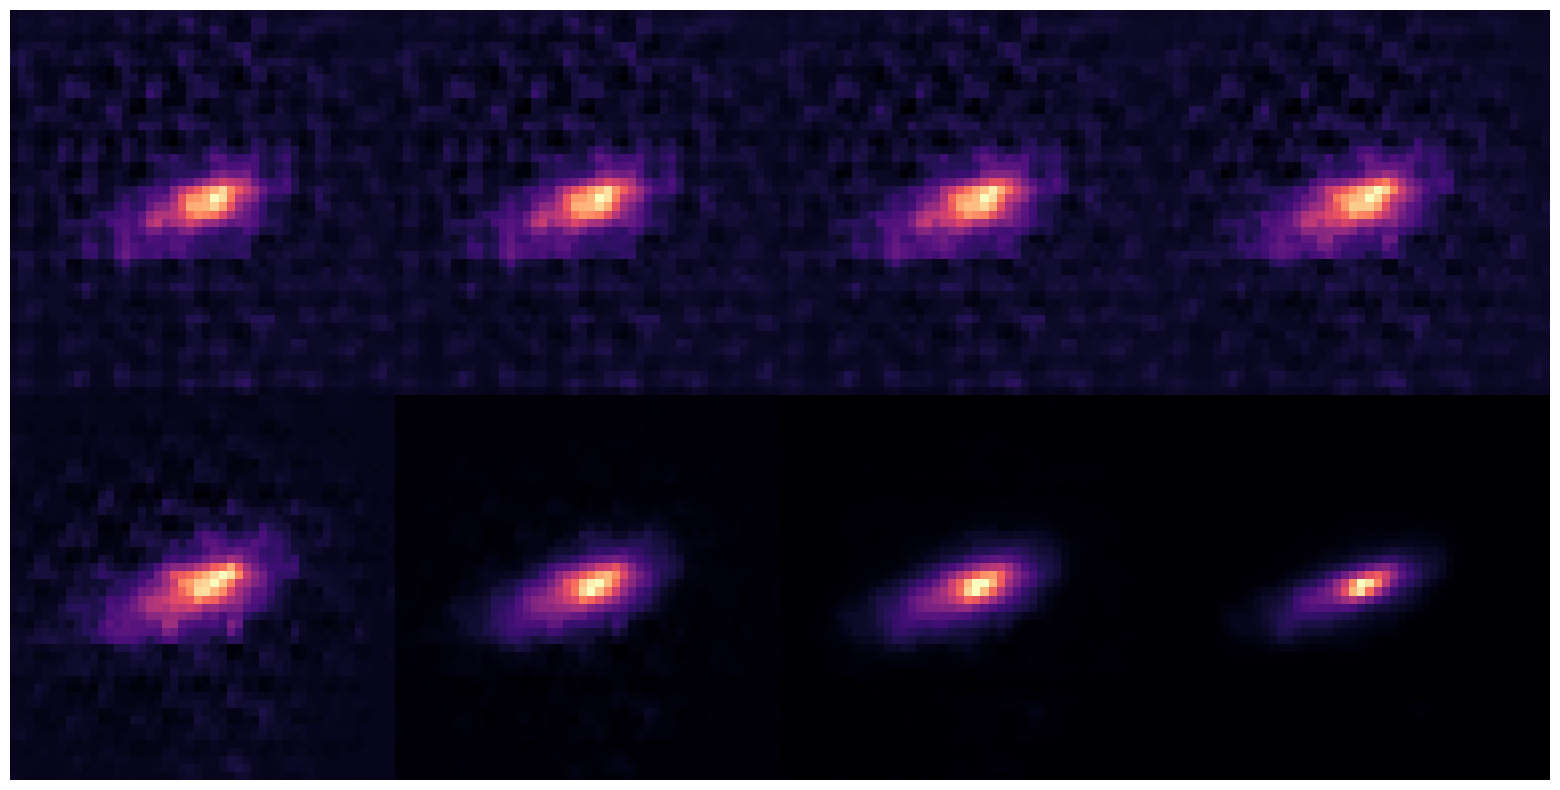

In [38]:
fig = plt.figure(figsize=(15.7,8), facecolor='white')
ax = plt.gca()
z_list = rec_admm[2][0][1]
gs = plt.GridSpec(2,4)
for idx, z in enumerate(z_list):
    ax = plt.subplot(gs[idx//4,idx%4])
    plt.imshow(z, cmap=cmap)
    plt.axis('off')
    ax.set_aspect('equal')
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('../figures/layers8.png', dpi=128, bbox_inches='tight')